# LightGBM
### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*

## Loading data

In [77]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cha                     1206 non-null   int64  
 1   perception              1206 non-null   int64  
 2   int                     1206 non-null   int64  
 3   str                     1206 non-null   int64  
 4   wis                     1206 non-null   int64  
 5   con                     1206 non-null   int64  
 6   reflex                  1206 non-null   int64  
 7   ac                      1206 non-null   int64  
 8   land_speed              1206 non-null   float64
 9   hp                      1206 non-null   int64  
 10  book                    1206 non-null   object 
 11  fortitude               1206 non-null   int64  
 12  dex                     1206 non-null   int64  
 13  num_immunities          1206 non-null   int64  
 14  focus                   1206 non-null   

In [79]:
df.head()

,cha,perception,int,str,wis,con,reflex,ac,land_speed,hp,...,spells_nr_lvl_4,spells_nr_lvl_5,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg
0,1,20,1,7,2,5,19,29,30.0,215,...,0,0,0,0,0,0,23,22.0,0,0.0
1,1,16,-4,9,2,5,14,28,35.0,220,...,0,0,0,0,0,0,23,22.0,0,0.0
2,-2,17,-4,7,3,6,17,25,30.0,175,...,0,0,0,0,0,0,21,16.0,0,0.0
3,6,30,6,7,5,5,29,41,50.0,315,...,1,0,1,0,0,0,33,31.5,0,0.0
4,1,6,-1,-5,1,1,10,16,0.0,20,...,1,0,0,0,0,0,0,0.0,8,5.0


###### Level

In [80]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [81]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [82]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


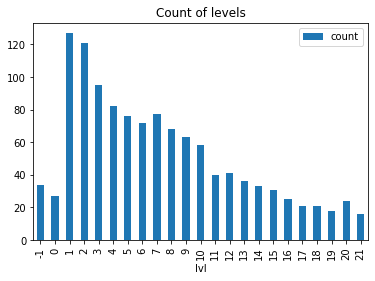

In [83]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")

plt.savefig(f"../results_diagrams/other/Count of levels.svg")

plt.show()

## Train test split

### Chronological split

In [84]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [85]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [86]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [87]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [88]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 45
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[86]	valid_0's l2: 0.925346	valid_0's l1: 0.464806


In [89]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.96
MAE: 0.46


In [91]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "full", rmse, mae]

In [92]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.13
RMSE test: 0.96


###### MAE by level

In [93]:
from training.results import plot_mae_by_level

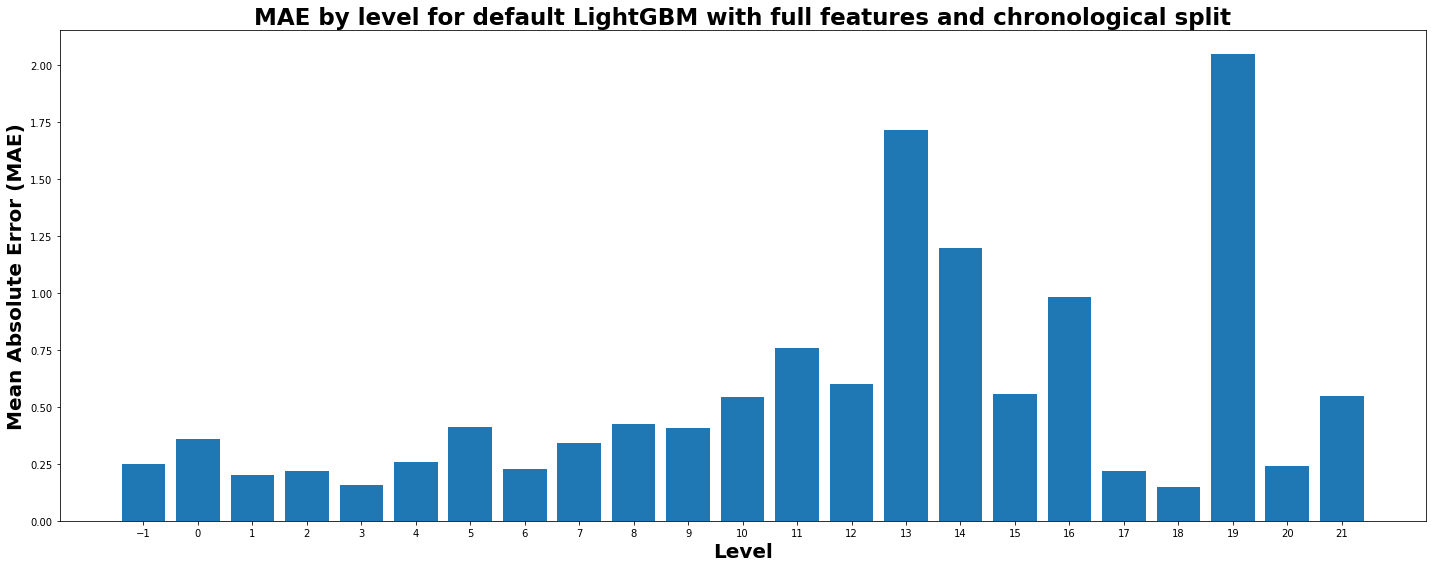

In [94]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with full features and chronological split",
)

In [95]:
from training.results import evaluate_round_predictions, plot_confusion_matrix


evaluate_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.96

Round type: 0.5
RMSE: 0.99

Round type: 0.33
RMSE: 0.94

Round type: 0.45
RMSE: 0.96



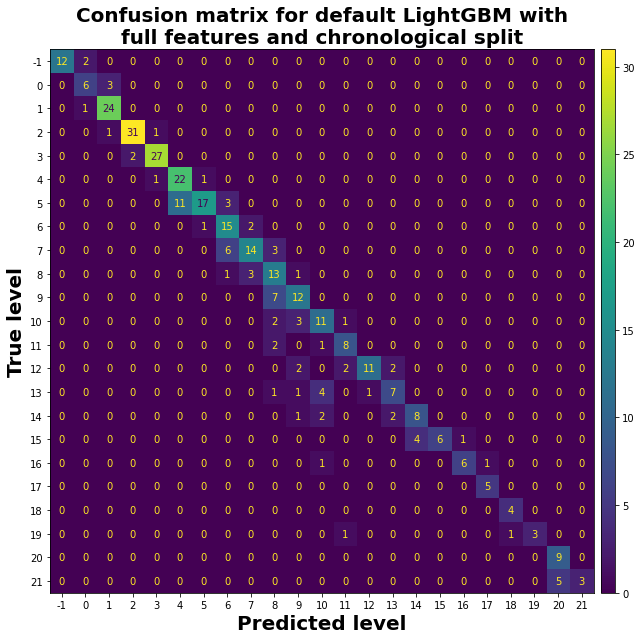

In [96]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with\nfull features and chronological split",
)

#### Tuning

In [97]:
from training.results import assess_regression_model

In [98]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-25 18:06:30,267] A new study created in memory with name: no-name-fa942108-3b28-46e8-8ddc-2fb528515073
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.140311 + 0.0294919
[200]	cv_agg's l2: 0.136209 + 0.0283978
[300]	cv_agg's l2: 0.135758 + 0.0286044
[400]	cv_agg's l2: 0.135251 + 0.0285188


feature_fraction, val_score: 0.135111:  14%|######4                                      | 1/7 [00:02<00:17,  3.00s/it]

[500]	cv_agg's l2: 0.135201 + 0.0282941
Early stopping, best iteration is:
[415]	cv_agg's l2: 0.135111 + 0.0284396
[100]	cv_agg's l2: 0.142273 + 0.037953
[200]	cv_agg's l2: 0.138274 + 0.0363961
[300]	cv_agg's l2: 0.137481 + 0.0353441
[400]	cv_agg's l2: 0.136854 + 0.035265


feature_fraction, val_score: 0.135111:  29%|############8                                | 2/7 [00:06<00:17,  3.57s/it]

[500]	cv_agg's l2: 0.13666 + 0.0350902
Early stopping, best iteration is:
[415]	cv_agg's l2: 0.135111 + 0.0284396
[100]	cv_agg's l2: 0.148404 + 0.0331389
[200]	cv_agg's l2: 0.14436 + 0.0318297
[300]	cv_agg's l2: 0.144326 + 0.0319602
[400]	cv_agg's l2: 0.143945 + 0.0318374


feature_fraction, val_score: 0.135111:  43%|###################2                         | 3/7 [00:11<00:15,  3.88s/it]

[500]	cv_agg's l2: 0.1439 + 0.0315536
Early stopping, best iteration is:
[415]	cv_agg's l2: 0.135111 + 0.0284396
[100]	cv_agg's l2: 0.154209 + 0.0353285
[200]	cv_agg's l2: 0.15155 + 0.0359125
[300]	cv_agg's l2: 0.151393 + 0.0356411
[400]	cv_agg's l2: 0.151537 + 0.0356715


feature_fraction, val_score: 0.135111:  57%|#########################7                   | 4/7 [00:14<00:11,  3.78s/it]

[500]	cv_agg's l2: 0.151629 + 0.0359523
Early stopping, best iteration is:
[415]	cv_agg's l2: 0.135111 + 0.0284396
[100]	cv_agg's l2: 0.147717 + 0.034079
[200]	cv_agg's l2: 0.142389 + 0.032341
[300]	cv_agg's l2: 0.142206 + 0.0318526
[400]	cv_agg's l2: 0.141914 + 0.0316362


feature_fraction, val_score: 0.135111:  71%|################################1            | 5/7 [00:18<00:07,  3.83s/it]

[500]	cv_agg's l2: 0.141987 + 0.0315848
Early stopping, best iteration is:
[415]	cv_agg's l2: 0.135111 + 0.0284396
[100]	cv_agg's l2: 0.146161 + 0.0334119
[200]	cv_agg's l2: 0.144317 + 0.0330302
[300]	cv_agg's l2: 0.144121 + 0.0337734
[400]	cv_agg's l2: 0.143851 + 0.0334978


feature_fraction, val_score: 0.135111:  86%|######################################5      | 6/7 [00:22<00:03,  3.87s/it]

[500]	cv_agg's l2: 0.143696 + 0.0334865
Early stopping, best iteration is:
[415]	cv_agg's l2: 0.135111 + 0.0284396
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


feature_fraction, val_score: 0.132613: 100%|#############################################| 7/7 [00:29<00:00,  4.26s/it]


Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041


num_leaves, val_score: 0.132613:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:   5%|##5                                               | 1/20 [00:07<02:24,  7.63s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  10%|#####                                             | 2/20 [00:14<02:09,  7.18s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  15%|#######5                                          | 3/20 [00:21<01:58,  6.99s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  20%|##########                                        | 4/20 [00:28<01:52,  7.06s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  25%|############5                                     | 5/20 [00:35<01:44,  6.95s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  30%|###############                                   | 6/20 [00:42<01:37,  6.97s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  35%|#################5                                | 7/20 [00:48<01:29,  6.89s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  40%|####################                              | 8/20 [00:55<01:22,  6.87s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.144004 + 0.0353976
[200]	cv_agg's l2: 0.13749 + 0.0339645
[300]	cv_agg's l2: 0.135502 + 0.0330887
[400]	cv_agg's l2: 0.134888 + 0.0326007
[500]	cv_agg's l2: 0.134988 + 0.0321883
[600]	cv_agg's l2: 0.135162 + 0.0316498
[700]	cv_agg's l2: 0.135066 + 0.0317732
[800]	cv_agg's l2: 0.135123 + 0.0314937


num_leaves, val_score: 0.132613:  45%|######################5                           | 9/20 [00:59<01:05,  5.94s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  50%|########################5                        | 10/20 [01:06<01:02,  6.21s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  55%|##########################9                      | 11/20 [01:13<00:57,  6.36s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  60%|#############################4                   | 12/20 [01:19<00:51,  6.50s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  65%|###############################8                 | 13/20 [01:27<00:46,  6.66s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  70%|##################################3              | 14/20 [01:33<00:40,  6.72s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  75%|####################################7            | 15/20 [01:40<00:33,  6.80s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  80%|#######################################2         | 16/20 [01:47<00:26,  6.73s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  85%|#########################################6       | 17/20 [01:54<00:20,  6.78s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  90%|############################################1    | 18/20 [02:00<00:13,  6.74s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613:  95%|##############################################5  | 19/20 [02:08<00:06,  6.92s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
[800]	cv_agg's l2: 0.132636 + 0.0272327


num_leaves, val_score: 0.132613: 100%|#################################################| 20/20 [02:15<00:00,  6.76s/it]


Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041


bagging, val_score: 0.132613:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.1684 + 0.0335657
[200]	cv_agg's l2: 0.159394 + 0.0317021
[300]	cv_agg's l2: 0.158367 + 0.0313945
[400]	cv_agg's l2: 0.158152 + 0.0304817
[500]	cv_agg's l2: 0.158645 + 0.0304725
[600]	cv_agg's l2: 0.160921 + 0.0303033
[700]	cv_agg's l2: 0.160899 + 0.0298975
[800]	cv_agg's l2: 0.162417 + 0.0289464


bagging, val_score: 0.132613:  10%|#####3                                               | 1/10 [00:04<00:38,  4.29s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.132613 + 0.0272041
[100]	cv_agg's l2: 0.135762 + 0.0267901
[200]	cv_agg's l2: 0.130929 + 0.0251357
[300]	cv_agg's l2: 0.129825 + 0.0243707
[400]	cv_agg's l2: 0.129435 + 0.0238749
[500]	cv_agg's l2: 0.12907 + 0.0237819
[600]	cv_agg's l2: 0.128915 + 0.0235734
[700]	cv_agg's l2: 0.12891 + 0.0235499


bagging, val_score: 0.128850:  20%|##########6                                          | 2/10 [00:10<00:41,  5.15s/it]

Early stopping, best iteration is:
[624]	cv_agg's l2: 0.12885 + 0.0235492
[100]	cv_agg's l2: 0.137801 + 0.0298143
[200]	cv_agg's l2: 0.131938 + 0.0269244
[300]	cv_agg's l2: 0.130126 + 0.026303
[400]	cv_agg's l2: 0.130022 + 0.0267555
[500]	cv_agg's l2: 0.129588 + 0.0266907
[600]	cv_agg's l2: 0.129572 + 0.0266908
[700]	cv_agg's l2: 0.129635 + 0.0268576
Early stopping, best iteration is:
[624]	cv_agg's l2: 0.12885 + 0.0235492


bagging, val_score: 0.128850:  30%|###############9                                     | 3/10 [00:15<00:37,  5.33s/it]

[100]	cv_agg's l2: 0.134691 + 0.0309609
[200]	cv_agg's l2: 0.131135 + 0.0286788
[300]	cv_agg's l2: 0.129921 + 0.0285162
[400]	cv_agg's l2: 0.129861 + 0.0285556
[500]	cv_agg's l2: 0.130051 + 0.0285569
[600]	cv_agg's l2: 0.129959 + 0.0282785


bagging, val_score: 0.128850:  30%|###############9                                     | 3/10 [00:21<00:37,  5.33s/it]

[700]	cv_agg's l2: 0.129868 + 0.0281342
Early stopping, best iteration is:
[624]	cv_agg's l2: 0.12885 + 0.0235492


bagging, val_score: 0.128850:  40%|#####################2                               | 4/10 [00:21<00:32,  5.45s/it]

[100]	cv_agg's l2: 0.135677 + 0.030297
[200]	cv_agg's l2: 0.132029 + 0.0284892
[300]	cv_agg's l2: 0.131282 + 0.0278211
[400]	cv_agg's l2: 0.131244 + 0.0278203
[500]	cv_agg's l2: 0.131297 + 0.0276751
[600]	cv_agg's l2: 0.13114 + 0.0276854


bagging, val_score: 0.128850:  40%|#####################2                               | 4/10 [00:26<00:32,  5.45s/it]

[700]	cv_agg's l2: 0.131067 + 0.0276999
Early stopping, best iteration is:
[624]	cv_agg's l2: 0.12885 + 0.0235492


bagging, val_score: 0.128850:  50%|##########################5                          | 5/10 [00:26<00:27,  5.53s/it]

[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618
[600]	cv_agg's l2: 0.132791 + 0.0273177
[700]	cv_agg's l2: 0.132641 + 0.0272019
Early stopping, best iteration is:
[624]	cv_agg's l2: 0.12885 + 0.0235492


bagging, val_score: 0.128850:  60%|###############################8                     | 6/10 [00:32<00:22,  5.57s/it]

[100]	cv_agg's l2: 0.13406 + 0.0313697
[200]	cv_agg's l2: 0.130609 + 0.0298998
[300]	cv_agg's l2: 0.128896 + 0.0290903
[400]	cv_agg's l2: 0.128846 + 0.0293972
[500]	cv_agg's l2: 0.128657 + 0.0297067


bagging, val_score: 0.128601:  70%|#####################################                | 7/10 [00:37<00:15,  5.27s/it]

Early stopping, best iteration is:
[490]	cv_agg's l2: 0.128601 + 0.0296503
[100]	cv_agg's l2: 0.137604 + 0.028626
[200]	cv_agg's l2: 0.134148 + 0.0281523
[300]	cv_agg's l2: 0.133723 + 0.0275728
[400]	cv_agg's l2: 0.133067 + 0.0273231
[500]	cv_agg's l2: 0.132938 + 0.0273618


bagging, val_score: 0.128601:  80%|##########################################4          | 8/10 [00:41<00:10,  5.10s/it]

Early stopping, best iteration is:
[490]	cv_agg's l2: 0.128601 + 0.0296503
[100]	cv_agg's l2: 0.141162 + 0.0329632
[200]	cv_agg's l2: 0.136695 + 0.0320581
[300]	cv_agg's l2: 0.135366 + 0.0318377
[400]	cv_agg's l2: 0.135116 + 0.0318086
[500]	cv_agg's l2: 0.135052 + 0.0319163


bagging, val_score: 0.128601:  90%|###############################################7     | 9/10 [00:46<00:04,  4.95s/it]

Early stopping, best iteration is:
[490]	cv_agg's l2: 0.128601 + 0.0296503
[100]	cv_agg's l2: 0.143348 + 0.0331074
[200]	cv_agg's l2: 0.139801 + 0.0340167
[300]	cv_agg's l2: 0.139173 + 0.0327359
[400]	cv_agg's l2: 0.138815 + 0.032626
[500]	cv_agg's l2: 0.138623 + 0.032646


bagging, val_score: 0.128601: 100%|####################################################| 10/10 [00:50<00:00,  5.08s/it]


Early stopping, best iteration is:
[490]	cv_agg's l2: 0.128601 + 0.0296503


feature_fraction_stage2, val_score: 0.128601:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.12913 + 0.0278157
[400]	cv_agg's l2: 0.128749 + 0.0274549
[500]	cv_agg's l2: 0.128369 + 0.0274996
[600]	cv_agg's l2: 0.128141 + 0.0275304
[700]	cv_agg's l2: 0.128106 + 0.0273973
[800]	cv_agg's l2: 0.128169 + 0.0274351
Early stopping, best iteration is:
[725]	cv_agg's l2: 0.128091 + 0.0273809


feature_fraction_stage2, val_score: 0.128091:  17%|######3                               | 1/6 [00:06<00:32,  6.45s/it]

[100]	cv_agg's l2: 0.134826 + 0.0289074
[200]	cv_agg's l2: 0.131332 + 0.026762
[300]	cv_agg's l2: 0.130742 + 0.0266061
[400]	cv_agg's l2: 0.13035 + 0.0266423
[500]	cv_agg's l2: 0.130047 + 0.0263097
[600]	cv_agg's l2: 0.129989 + 0.0263802
[700]	cv_agg's l2: 0.130044 + 0.0263491


feature_fraction_stage2, val_score: 0.128091:  17%|######3                               | 1/6 [00:13<00:32,  6.45s/it]

[800]	cv_agg's l2: 0.130085 + 0.0262881
Early stopping, best iteration is:
[725]	cv_agg's l2: 0.128091 + 0.0273809


feature_fraction_stage2, val_score: 0.128091:  33%|############6                         | 2/6 [00:13<00:26,  6.73s/it]

[100]	cv_agg's l2: 0.138443 + 0.0365501
[200]	cv_agg's l2: 0.132987 + 0.0344077
[300]	cv_agg's l2: 0.131887 + 0.0339369
[400]	cv_agg's l2: 0.131435 + 0.0340499
[500]	cv_agg's l2: 0.131244 + 0.0339114
[600]	cv_agg's l2: 0.131021 + 0.033684
[700]	cv_agg's l2: 0.131005 + 0.0337076
[800]	cv_agg's l2: 0.131041 + 0.0335861


feature_fraction_stage2, val_score: 0.128091:  50%|###################                   | 3/6 [00:19<00:19,  6.62s/it]

Early stopping, best iteration is:
[725]	cv_agg's l2: 0.128091 + 0.0273809
[100]	cv_agg's l2: 0.137827 + 0.0301828
[200]	cv_agg's l2: 0.133155 + 0.0287755
[300]	cv_agg's l2: 0.13249 + 0.0281134
[400]	cv_agg's l2: 0.132086 + 0.028122
[500]	cv_agg's l2: 0.132189 + 0.0281531
[600]	cv_agg's l2: 0.132051 + 0.0281579
[700]	cv_agg's l2: 0.132054 + 0.0280029
[800]	cv_agg's l2: 0.132047 + 0.0279883
Early stopping, best iteration is:
[725]	cv_agg's l2: 0.128091 + 0.0273809


feature_fraction_stage2, val_score: 0.128091:  67%|#########################3            | 4/6 [00:26<00:12,  6.50s/it]

[100]	cv_agg's l2: 0.134726 + 0.0297255
[200]	cv_agg's l2: 0.130105 + 0.0286258
[300]	cv_agg's l2: 0.129265 + 0.0285408
[400]	cv_agg's l2: 0.1292 + 0.0288877
[500]	cv_agg's l2: 0.129001 + 0.0287721
[600]	cv_agg's l2: 0.128938 + 0.0287901
[700]	cv_agg's l2: 0.128874 + 0.0287391


feature_fraction_stage2, val_score: 0.128091:  67%|#########################3            | 4/6 [00:32<00:12,  6.50s/it]

[800]	cv_agg's l2: 0.128954 + 0.0288331
Early stopping, best iteration is:
[725]	cv_agg's l2: 0.128091 + 0.0273809


feature_fraction_stage2, val_score: 0.128091:  83%|###############################6      | 5/6 [00:32<00:06,  6.44s/it]

[100]	cv_agg's l2: 0.136944 + 0.0304376
[200]	cv_agg's l2: 0.133011 + 0.0295109
[300]	cv_agg's l2: 0.132038 + 0.0286838
[400]	cv_agg's l2: 0.131956 + 0.0286919
[500]	cv_agg's l2: 0.131557 + 0.0283627
[600]	cv_agg's l2: 0.131528 + 0.0282936
[700]	cv_agg's l2: 0.131483 + 0.0284375
[800]	cv_agg's l2: 0.131514 + 0.0284693


feature_fraction_stage2, val_score: 0.128091: 100%|######################################| 6/6 [00:39<00:00,  6.51s/it]


Early stopping, best iteration is:
[725]	cv_agg's l2: 0.128091 + 0.0273809


regularization_factors, val_score: 0.128091:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.146192 + 0.0331048
[200]	cv_agg's l2: 0.141051 + 0.0316809
[300]	cv_agg's l2: 0.140505 + 0.0317974
[400]	cv_agg's l2: 0.140505 + 0.0317974
[500]	cv_agg's l2: 0.140505 + 0.0317974
[600]	cv_agg's l2: 0.140505 + 0.0317974


regularization_factors, val_score: 0.128091:   0%|                                              | 0/20 [00:02<?, ?it/s]

[700]	cv_agg's l2: 0.140505 + 0.0317974
[800]	cv_agg's l2: 0.140505 + 0.0317974
Early stopping, best iteration is:
[725]	cv_agg's l2: 0.128091 + 0.0273809


regularization_factors, val_score: 0.128091:   5%|#9                                    | 1/20 [00:02<00:44,  2.33s/it]

[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128789 + 0.0281505
[400]	cv_agg's l2: 0.128352 + 0.0279221
[500]	cv_agg's l2: 0.128136 + 0.0278545
[600]	cv_agg's l2: 0.127959 + 0.0278426
[700]	cv_agg's l2: 0.127859 + 0.0277753
[800]	cv_agg's l2: 0.127865 + 0.0278652


regularization_factors, val_score: 0.127815:  10%|###8                                  | 2/20 [00:09<01:32,  5.16s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128789 + 0.0281505
[400]	cv_agg's l2: 0.128352 + 0.0279221
[500]	cv_agg's l2: 0.128136 + 0.0278545
[600]	cv_agg's l2: 0.127959 + 0.0278426
[700]	cv_agg's l2: 0.127859 + 0.0277753
[800]	cv_agg's l2: 0.127863 + 0.0278665


regularization_factors, val_score: 0.127815:  15%|#####7                                | 3/20 [00:15<01:38,  5.77s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128789 + 0.0281505
[400]	cv_agg's l2: 0.128352 + 0.0279221
[500]	cv_agg's l2: 0.128136 + 0.0278545
[600]	cv_agg's l2: 0.127959 + 0.0278426
[700]	cv_agg's l2: 0.127859 + 0.0277753
[800]	cv_agg's l2: 0.127865 + 0.0278652


regularization_factors, val_score: 0.127815:  20%|#######6                              | 4/20 [00:22<01:35,  5.97s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128789 + 0.0281505
[400]	cv_agg's l2: 0.128352 + 0.0279221
[500]	cv_agg's l2: 0.128136 + 0.0278545
[600]	cv_agg's l2: 0.127959 + 0.0278426
[700]	cv_agg's l2: 0.127859 + 0.0277753
[800]	cv_agg's l2: 0.127863 + 0.0278665


regularization_factors, val_score: 0.127815:  25%|#########5                            | 5/20 [00:28<01:31,  6.10s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128789 + 0.0281505
[400]	cv_agg's l2: 0.128352 + 0.0279221
[500]	cv_agg's l2: 0.128136 + 0.0278545
[600]	cv_agg's l2: 0.127959 + 0.0278426
[700]	cv_agg's l2: 0.127859 + 0.0277753
[800]	cv_agg's l2: 0.127865 + 0.0278652


regularization_factors, val_score: 0.127815:  30%|###########4                          | 6/20 [00:34<01:26,  6.17s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128789 + 0.0281505
[400]	cv_agg's l2: 0.128352 + 0.0279221
[500]	cv_agg's l2: 0.128136 + 0.0278545
[600]	cv_agg's l2: 0.127959 + 0.0278426
[700]	cv_agg's l2: 0.127859 + 0.0277753
[800]	cv_agg's l2: 0.127865 + 0.0278652


regularization_factors, val_score: 0.127815:  35%|#############3                        | 7/20 [00:41<01:21,  6.29s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128789 + 0.0281505
[400]	cv_agg's l2: 0.128352 + 0.0279221
[500]	cv_agg's l2: 0.128136 + 0.0278545
[600]	cv_agg's l2: 0.127959 + 0.0278426
[700]	cv_agg's l2: 0.127859 + 0.0277753
[800]	cv_agg's l2: 0.127865 + 0.0278652


regularization_factors, val_score: 0.127815:  40%|###############2                      | 8/20 [00:48<01:17,  6.45s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128789 + 0.0281505
[400]	cv_agg's l2: 0.128352 + 0.0279221
[500]	cv_agg's l2: 0.128136 + 0.0278545
[600]	cv_agg's l2: 0.127959 + 0.0278426
[700]	cv_agg's l2: 0.127859 + 0.0277753
[800]	cv_agg's l2: 0.127865 + 0.0278652


regularization_factors, val_score: 0.127815:  45%|#################1                    | 9/20 [00:54<01:11,  6.50s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128789 + 0.0281505
[400]	cv_agg's l2: 0.128352 + 0.0279221
[500]	cv_agg's l2: 0.128136 + 0.0278545
[600]	cv_agg's l2: 0.127959 + 0.0278426
[700]	cv_agg's l2: 0.127859 + 0.0277753
[800]	cv_agg's l2: 0.127865 + 0.0278652


regularization_factors, val_score: 0.127815:  50%|##################5                  | 10/20 [01:01<01:04,  6.47s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128789 + 0.0281505
[400]	cv_agg's l2: 0.128352 + 0.0279221
[500]	cv_agg's l2: 0.128136 + 0.0278545
[600]	cv_agg's l2: 0.127959 + 0.0278426
[700]	cv_agg's l2: 0.127859 + 0.0277753
[800]	cv_agg's l2: 0.127865 + 0.0278652


regularization_factors, val_score: 0.127815:  55%|####################3                | 11/20 [01:08<00:59,  6.58s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128789 + 0.0281505
[400]	cv_agg's l2: 0.128352 + 0.0279221
[500]	cv_agg's l2: 0.128136 + 0.0278545
[600]	cv_agg's l2: 0.127959 + 0.0278426
[700]	cv_agg's l2: 0.127859 + 0.0277753
[800]	cv_agg's l2: 0.127865 + 0.0278652


regularization_factors, val_score: 0.127815:  60%|######################2              | 12/20 [01:14<00:52,  6.51s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128789 + 0.0281505
[400]	cv_agg's l2: 0.128352 + 0.0279221
[500]	cv_agg's l2: 0.128136 + 0.0278545
[600]	cv_agg's l2: 0.127959 + 0.0278426
[700]	cv_agg's l2: 0.127859 + 0.0277753
[800]	cv_agg's l2: 0.127865 + 0.0278652


regularization_factors, val_score: 0.127815:  65%|########################             | 13/20 [01:21<00:46,  6.59s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.135013 + 0.0300119
[200]	cv_agg's l2: 0.130304 + 0.0276897
[300]	cv_agg's l2: 0.129388 + 0.0274387
[400]	cv_agg's l2: 0.129251 + 0.0271315
[500]	cv_agg's l2: 0.12899 + 0.0269695
[600]	cv_agg's l2: 0.128741 + 0.0269483
[700]	cv_agg's l2: 0.128789 + 0.0269272
[800]	cv_agg's l2: 0.128799 + 0.0268996


regularization_factors, val_score: 0.127815:  70%|#########################9           | 14/20 [01:28<00:40,  6.79s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.135013 + 0.0300119
[200]	cv_agg's l2: 0.130304 + 0.0276897
[300]	cv_agg's l2: 0.129388 + 0.0274387
[400]	cv_agg's l2: 0.129251 + 0.0271315
[500]	cv_agg's l2: 0.128948 + 0.0270032
[600]	cv_agg's l2: 0.128773 + 0.0269226
[700]	cv_agg's l2: 0.128735 + 0.026945
[800]	cv_agg's l2: 0.128714 + 0.0269574


regularization_factors, val_score: 0.127815:  75%|###########################7         | 15/20 [01:35<00:34,  6.81s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.135013 + 0.0300119
[200]	cv_agg's l2: 0.130256 + 0.0277291
[300]	cv_agg's l2: 0.12936 + 0.0274613
[400]	cv_agg's l2: 0.129132 + 0.0272283
[500]	cv_agg's l2: 0.128839 + 0.0270918
[600]	cv_agg's l2: 0.128646 + 0.027026
[700]	cv_agg's l2: 0.12865 + 0.0270403
[800]	cv_agg's l2: 0.128617 + 0.0270641


regularization_factors, val_score: 0.127815:  80%|#############################6       | 16/20 [01:42<00:27,  6.86s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128766 + 0.028171
[400]	cv_agg's l2: 0.128367 + 0.0281317
[500]	cv_agg's l2: 0.128117 + 0.0279449
[600]	cv_agg's l2: 0.127917 + 0.0278842
[700]	cv_agg's l2: 0.127903 + 0.0279302
[800]	cv_agg's l2: 0.12789 + 0.0279757


regularization_factors, val_score: 0.127815:  85%|###############################4     | 17/20 [01:49<00:20,  6.98s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128766 + 0.028171
[400]	cv_agg's l2: 0.128367 + 0.0281317
[500]	cv_agg's l2: 0.128117 + 0.0279449
[600]	cv_agg's l2: 0.127917 + 0.0278842
[700]	cv_agg's l2: 0.127903 + 0.0279302
[800]	cv_agg's l2: 0.12789 + 0.0279757


regularization_factors, val_score: 0.127815:  90%|#################################3   | 18/20 [01:56<00:13,  6.91s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128789 + 0.0281505
[400]	cv_agg's l2: 0.128352 + 0.0279221
[500]	cv_agg's l2: 0.128136 + 0.0278545
[600]	cv_agg's l2: 0.127959 + 0.0278426
[700]	cv_agg's l2: 0.127859 + 0.0277753
[800]	cv_agg's l2: 0.127865 + 0.0278652


regularization_factors, val_score: 0.127815:  95%|###################################1 | 19/20 [02:03<00:06,  6.89s/it]

Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173
[100]	cv_agg's l2: 0.134316 + 0.030836
[200]	cv_agg's l2: 0.129659 + 0.0284486
[300]	cv_agg's l2: 0.128789 + 0.0281505
[400]	cv_agg's l2: 0.128352 + 0.0279221
[500]	cv_agg's l2: 0.128136 + 0.0278545
[600]	cv_agg's l2: 0.127959 + 0.0278426
[700]	cv_agg's l2: 0.127859 + 0.0277753
[800]	cv_agg's l2: 0.127865 + 0.0278652


regularization_factors, val_score: 0.127815: 100%|#####################################| 20/20 [02:09<00:00,  6.49s/it]


Early stopping, best iteration is:
[776]	cv_agg's l2: 0.127815 + 0.0278173


min_data_in_leaf, val_score: 0.127815:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.119896 + 0.0217027
[200]	cv_agg's l2: 0.119827 + 0.0214952


min_data_in_leaf, val_score: 0.119520:  20%|#########                                    | 1/5 [00:02<00:08,  2.22s/it]

Early stopping, best iteration is:
[129]	cv_agg's l2: 0.11952 + 0.0216207
[100]	cv_agg's l2: 0.71065 + 0.122893


min_data_in_leaf, val_score: 0.119520:  40%|##################                           | 2/5 [00:02<00:04,  1.35s/it]

[200]	cv_agg's l2: 0.676496 + 0.130505
Early stopping, best iteration is:
[129]	cv_agg's l2: 0.11952 + 0.0216207
[100]	cv_agg's l2: 0.221049 + 0.0519863


min_data_in_leaf, val_score: 0.119520:  60%|###########################                  | 3/5 [00:03<00:02,  1.19s/it]

[200]	cv_agg's l2: 0.208163 + 0.0497933
Early stopping, best iteration is:
[129]	cv_agg's l2: 0.11952 + 0.0216207
[100]	cv_agg's l2: 0.123203 + 0.0240908
[200]	cv_agg's l2: 0.122454 + 0.0239903


min_data_in_leaf, val_score: 0.119520:  80%|####################################         | 4/5 [00:06<00:01,  1.59s/it]

Early stopping, best iteration is:
[129]	cv_agg's l2: 0.11952 + 0.0216207
[100]	cv_agg's l2: 0.15831 + 0.0448918


min_data_in_leaf, val_score: 0.119520:  80%|####################################         | 4/5 [00:07<00:01,  1.59s/it]

[200]	cv_agg's l2: 0.152424 + 0.0422176
Early stopping, best iteration is:
[129]	cv_agg's l2: 0.11952 + 0.0216207


min_data_in_leaf, val_score: 0.119520: 100%|#############################################| 5/5 [00:07<00:00,  1.54s/it]


In [99]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.11951970270643175
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.3018668475036848e-08
    lambda_l2: 2.5074024976365225e-08
    num_leaves: 31
    feature_fraction: 0.58
    bagging_fraction: 0.992119885016315
    bagging_freq: 7
    min_child_samples: 5


In [100]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [101]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.73
MAE test: 0.41



In [102]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "full",
    rmse,
    mae,
]

###### MAE by level

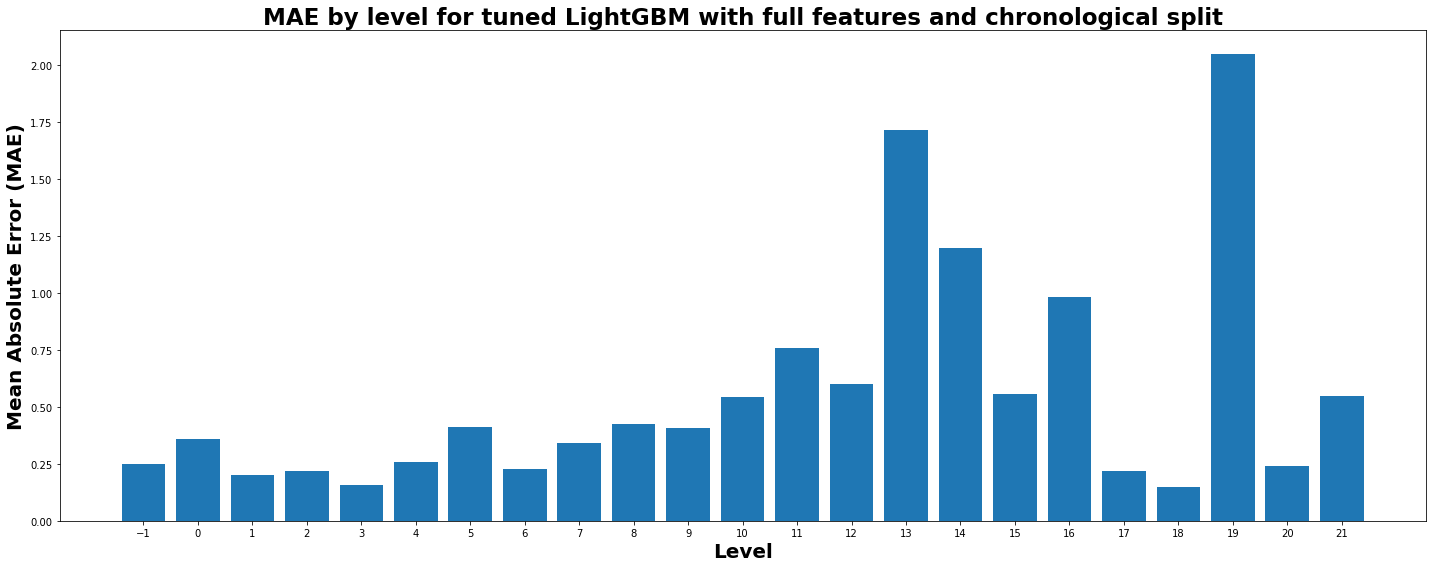

In [103]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with full features and chronological split",
    export=True,
)

In [104]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.73

Round type: 0.5
RMSE: 0.75

Round type: 0.33
RMSE: 0.74

Round type: 0.45
RMSE: 0.73



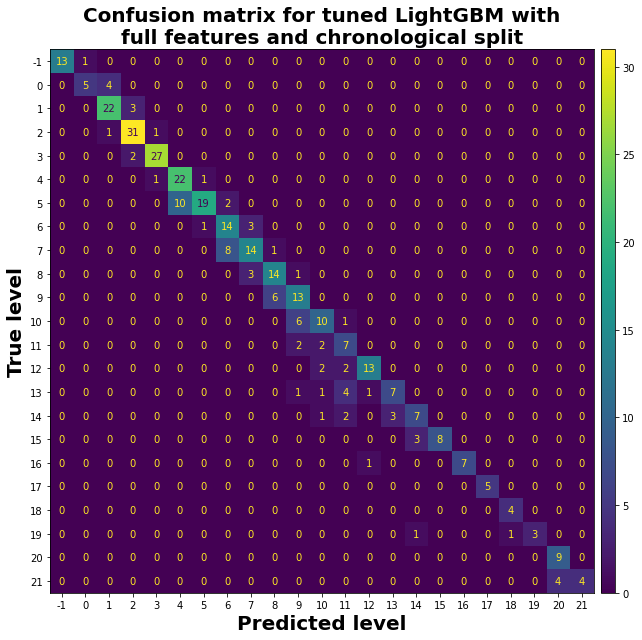

In [105]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with\nfull features and chronological split",
    export=True,
)

## Random split

In [106]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 48
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	valid_0's l2: 0.1379	valid_0's l1: 0.246737


In [107]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.37
MAE: 0.25


In [109]:
results.loc[2] = ["random", "default", "full", rmse, mae]

###### MAE by level

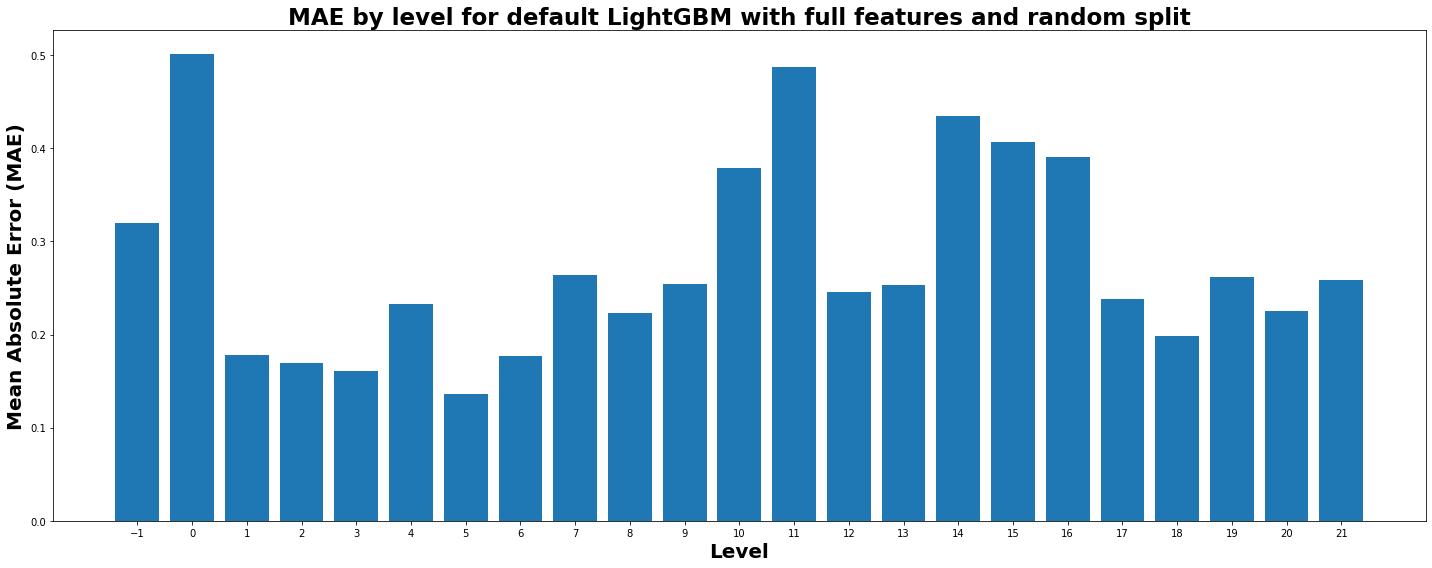

In [110]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with full features and random split",
)

In [111]:
evaluate_round_predictions([0.5, 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.37

Round type: 0.5
RMSE: 0.38

Round type: 0.33
RMSE: 0.43

Round type: 0.45
RMSE: 0.38



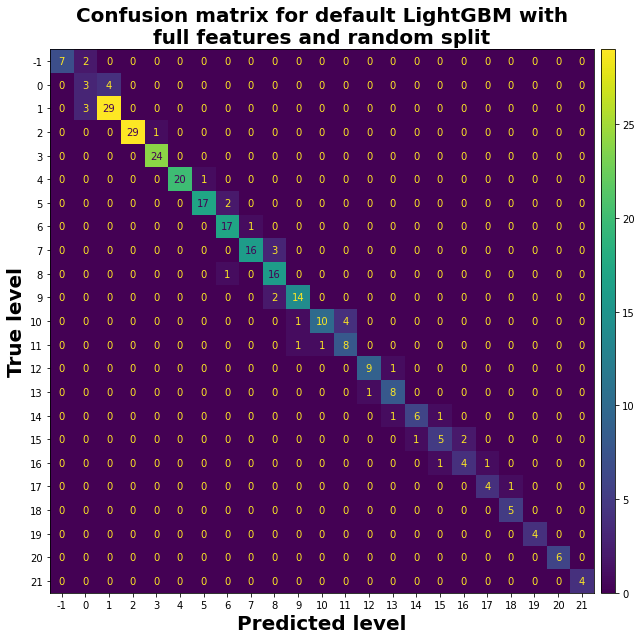

In [112]:
plot_confusion_matrix(
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with\nfull features and random split",
)

### Tuning

In [113]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-25 18:13:15,561] A new study created in memory with name: no-name-2324b821-f6fb-4bca-a589-09c9953ceeca
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.156984 + 0.048974
[200]	cv_agg's l2: 0.152589 + 0.0449877
[300]	cv_agg's l2: 0.151187 + 0.0438106
[400]	cv_agg's l2: 0.150254 + 0.0432927
[500]	cv_agg's l2: 0.149791 + 0.0427453
[600]	cv_agg's l2: 0.149719 + 0.0427652
[700]	cv_agg's l2: 0.149567 + 0.0425314
[800]	cv_agg's l2: 0.149413 + 0.0424027
[900]	cv_agg's l2: 0.149274 + 0.0423217
[1000]	cv_agg's l2: 0.149255 + 0.0422904
[1100]	cv_agg's l2: 0.149196 + 0.0422608
[1200]	cv_agg's l2: 0.149113 + 0.0422372
[1300]	cv_agg's l2: 0.149094 + 0.0422292


feature_fraction, val_score: 0.149082:  14%|######4                                      | 1/7 [00:10<01:02, 10.43s/it]

Early stopping, best iteration is:
[1247]	cv_agg's l2: 0.149082 + 0.0422141
[100]	cv_agg's l2: 0.17351 + 0.0426452
[200]	cv_agg's l2: 0.169233 + 0.0410951
[300]	cv_agg's l2: 0.167794 + 0.0399741
[400]	cv_agg's l2: 0.167584 + 0.03992
[500]	cv_agg's l2: 0.167618 + 0.0398984
[600]	cv_agg's l2: 0.167828 + 0.0398483
[700]	cv_agg's l2: 0.167753 + 0.0397151
[800]	cv_agg's l2: 0.167701 + 0.0396111
[900]	cv_agg's l2: 0.167748 + 0.0395253
[1000]	cv_agg's l2: 0.167758 + 0.0394465
[1100]	cv_agg's l2: 0.167745 + 0.0393902
[1200]	cv_agg's l2: 0.167686 + 0.0392797
[1300]	cv_agg's l2: 0.167671 + 0.0392205


feature_fraction, val_score: 0.149082:  29%|############8                                | 2/7 [00:23<01:00, 12.12s/it]

Early stopping, best iteration is:
[1247]	cv_agg's l2: 0.149082 + 0.0422141
[100]	cv_agg's l2: 0.162194 + 0.0427761
[200]	cv_agg's l2: 0.158367 + 0.0407238
[300]	cv_agg's l2: 0.15724 + 0.0396193
[400]	cv_agg's l2: 0.157313 + 0.0392552
[500]	cv_agg's l2: 0.157069 + 0.0389637
[600]	cv_agg's l2: 0.156992 + 0.0389245
[700]	cv_agg's l2: 0.156851 + 0.0386013
[800]	cv_agg's l2: 0.156817 + 0.0385424
[900]	cv_agg's l2: 0.156836 + 0.0385073
[1000]	cv_agg's l2: 0.15685 + 0.0385241
[1100]	cv_agg's l2: 0.156891 + 0.0385357
[1200]	cv_agg's l2: 0.156915 + 0.0385454
[1300]	cv_agg's l2: 0.156924 + 0.0385502


feature_fraction, val_score: 0.149082:  43%|###################2                         | 3/7 [00:34<00:45, 11.34s/it]

Early stopping, best iteration is:
[1247]	cv_agg's l2: 0.149082 + 0.0422141
[100]	cv_agg's l2: 0.152753 + 0.0514921
[200]	cv_agg's l2: 0.147625 + 0.0466894
[300]	cv_agg's l2: 0.146886 + 0.0457202
[400]	cv_agg's l2: 0.146157 + 0.0447444
[500]	cv_agg's l2: 0.14588 + 0.0446184
[600]	cv_agg's l2: 0.145649 + 0.0443671
[700]	cv_agg's l2: 0.145606 + 0.0442502
[800]	cv_agg's l2: 0.145564 + 0.0441801
[900]	cv_agg's l2: 0.145519 + 0.0441772


feature_fraction, val_score: 0.145492:  57%|#########################7                   | 4/7 [00:42<00:30, 10.04s/it]

Early stopping, best iteration is:
[878]	cv_agg's l2: 0.145492 + 0.0441524
[100]	cv_agg's l2: 0.169955 + 0.0459805
[200]	cv_agg's l2: 0.166714 + 0.0439395
[300]	cv_agg's l2: 0.165965 + 0.0441793
[400]	cv_agg's l2: 0.165687 + 0.0441846
[500]	cv_agg's l2: 0.165487 + 0.0438588
[600]	cv_agg's l2: 0.165444 + 0.0436017
[700]	cv_agg's l2: 0.165336 + 0.0433991
[800]	cv_agg's l2: 0.165246 + 0.0432547
[900]	cv_agg's l2: 0.165199 + 0.0431162


feature_fraction, val_score: 0.145492:  71%|################################1            | 5/7 [00:50<00:18,  9.28s/it]

Early stopping, best iteration is:
[878]	cv_agg's l2: 0.145492 + 0.0441524
[100]	cv_agg's l2: 0.171395 + 0.0513676
[200]	cv_agg's l2: 0.167365 + 0.0494024
[300]	cv_agg's l2: 0.166512 + 0.0487646
[400]	cv_agg's l2: 0.166172 + 0.0484842
[500]	cv_agg's l2: 0.16626 + 0.0483354
[600]	cv_agg's l2: 0.166312 + 0.0482423
[700]	cv_agg's l2: 0.166372 + 0.0481714
[800]	cv_agg's l2: 0.166404 + 0.048088
[900]	cv_agg's l2: 0.166407 + 0.0480444


feature_fraction, val_score: 0.145492:  86%|######################################5      | 6/7 [00:57<00:08,  8.60s/it]

Early stopping, best iteration is:
[878]	cv_agg's l2: 0.145492 + 0.0441524
[100]	cv_agg's l2: 0.166604 + 0.0544027
[200]	cv_agg's l2: 0.161763 + 0.0511945
[300]	cv_agg's l2: 0.160742 + 0.0493065
[400]	cv_agg's l2: 0.160239 + 0.0486908
[500]	cv_agg's l2: 0.160163 + 0.0481242
[600]	cv_agg's l2: 0.160072 + 0.0480743
[700]	cv_agg's l2: 0.159933 + 0.047967
[800]	cv_agg's l2: 0.159986 + 0.0479161
[900]	cv_agg's l2: 0.159917 + 0.047857


feature_fraction, val_score: 0.145492: 100%|#############################################| 7/7 [01:05<00:00,  9.37s/it]


Early stopping, best iteration is:
[878]	cv_agg's l2: 0.145492 + 0.0441524


num_leaves, val_score: 0.145492:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.152753 + 0.0514921
[200]	cv_agg's l2: 0.147625 + 0.0466894
[300]	cv_agg's l2: 0.146886 + 0.0457202
[400]	cv_agg's l2: 0.146157 + 0.0447444
[500]	cv_agg's l2: 0.14588 + 0.0446184
[600]	cv_agg's l2: 0.145649 + 0.0443671
[700]	cv_agg's l2: 0.145606 + 0.0442502
[800]	cv_agg's l2: 0.145564 + 0.0441801
[900]	cv_agg's l2: 0.145519 + 0.0441772


num_leaves, val_score: 0.145492:   5%|##5                                               | 1/20 [00:07<02:30,  7.90s/it]

Early stopping, best iteration is:
[878]	cv_agg's l2: 0.145492 + 0.0441524
[100]	cv_agg's l2: 0.152753 + 0.0514921
[200]	cv_agg's l2: 0.147625 + 0.0466894
[300]	cv_agg's l2: 0.146886 + 0.0457202
[400]	cv_agg's l2: 0.146157 + 0.0447444
[500]	cv_agg's l2: 0.14588 + 0.0446184
[600]	cv_agg's l2: 0.145649 + 0.0443671
[700]	cv_agg's l2: 0.145606 + 0.0442502
[800]	cv_agg's l2: 0.145564 + 0.0441801
[900]	cv_agg's l2: 0.145519 + 0.0441772


num_leaves, val_score: 0.145492:  10%|#####                                             | 2/20 [00:15<02:19,  7.73s/it]

Early stopping, best iteration is:
[878]	cv_agg's l2: 0.145492 + 0.0441524
[100]	cv_agg's l2: 0.152753 + 0.0514921
[200]	cv_agg's l2: 0.147625 + 0.0466894
[300]	cv_agg's l2: 0.146886 + 0.0457202
[400]	cv_agg's l2: 0.146157 + 0.0447444
[500]	cv_agg's l2: 0.14588 + 0.0446184
[600]	cv_agg's l2: 0.145649 + 0.0443671
[700]	cv_agg's l2: 0.145606 + 0.0442502
[800]	cv_agg's l2: 0.145564 + 0.0441801
[900]	cv_agg's l2: 0.145519 + 0.0441772


num_leaves, val_score: 0.145492:  15%|#######5                                          | 3/20 [00:22<02:05,  7.38s/it]

Early stopping, best iteration is:
[878]	cv_agg's l2: 0.145492 + 0.0441524
[100]	cv_agg's l2: 0.152753 + 0.0514921
[200]	cv_agg's l2: 0.147625 + 0.0466894
[300]	cv_agg's l2: 0.146886 + 0.0457202
[400]	cv_agg's l2: 0.146157 + 0.0447444
[500]	cv_agg's l2: 0.14588 + 0.0446184
[600]	cv_agg's l2: 0.145649 + 0.0443671
[700]	cv_agg's l2: 0.145606 + 0.0442502
[800]	cv_agg's l2: 0.145564 + 0.0441801
[900]	cv_agg's l2: 0.145519 + 0.0441772


num_leaves, val_score: 0.145492:  20%|##########                                        | 4/20 [00:29<01:58,  7.39s/it]

Early stopping, best iteration is:
[878]	cv_agg's l2: 0.145492 + 0.0441524
[100]	cv_agg's l2: 0.287059 + 0.0487459
[200]	cv_agg's l2: 0.242153 + 0.0419972
[300]	cv_agg's l2: 0.231481 + 0.0419462
[400]	cv_agg's l2: 0.225963 + 0.0425744
[500]	cv_agg's l2: 0.221649 + 0.0444934
[600]	cv_agg's l2: 0.218261 + 0.0454912
[700]	cv_agg's l2: 0.215119 + 0.0457172
[800]	cv_agg's l2: 0.212356 + 0.0460375


num_leaves, val_score: 0.145492:  25%|############5                                     | 5/20 [00:31<01:20,  5.39s/it]

[900]	cv_agg's l2: 0.209703 + 0.0461887
Early stopping, best iteration is:
[878]	cv_agg's l2: 0.145492 + 0.0441524
[100]	cv_agg's l2: 0.161442 + 0.0472674
[200]	cv_agg's l2: 0.15142 + 0.0444852
[300]	cv_agg's l2: 0.146644 + 0.0429692
[400]	cv_agg's l2: 0.144361 + 0.0423603
[500]	cv_agg's l2: 0.143257 + 0.0408838
[600]	cv_agg's l2: 0.142145 + 0.0399456
[700]	cv_agg's l2: 0.141605 + 0.0393394
[800]	cv_agg's l2: 0.141521 + 0.0390962
[900]	cv_agg's l2: 0.141637 + 0.0386102


num_leaves, val_score: 0.141435:  30%|###############                                   | 6/20 [00:35<01:06,  4.72s/it]

Early stopping, best iteration is:
[872]	cv_agg's l2: 0.141435 + 0.0386315
[100]	cv_agg's l2: 0.152753 + 0.0514921
[200]	cv_agg's l2: 0.147625 + 0.0466894
[300]	cv_agg's l2: 0.146886 + 0.0457202
[400]	cv_agg's l2: 0.146157 + 0.0447444
[500]	cv_agg's l2: 0.14588 + 0.0446184
[600]	cv_agg's l2: 0.145649 + 0.0443671
[700]	cv_agg's l2: 0.145606 + 0.0442502
[800]	cv_agg's l2: 0.145564 + 0.0441801
[900]	cv_agg's l2: 0.145519 + 0.0441772


num_leaves, val_score: 0.141435:  35%|#################5                                | 7/20 [00:43<01:15,  5.81s/it]

Early stopping, best iteration is:
[872]	cv_agg's l2: 0.141435 + 0.0386315
[100]	cv_agg's l2: 0.152753 + 0.0514921
[200]	cv_agg's l2: 0.147625 + 0.0466894
[300]	cv_agg's l2: 0.146886 + 0.0457202
[400]	cv_agg's l2: 0.146157 + 0.0447444
[500]	cv_agg's l2: 0.14588 + 0.0446184
[600]	cv_agg's l2: 0.145649 + 0.0443671
[700]	cv_agg's l2: 0.145606 + 0.0442502
[800]	cv_agg's l2: 0.145564 + 0.0441801
[900]	cv_agg's l2: 0.145519 + 0.0441772


num_leaves, val_score: 0.141435:  40%|####################                              | 8/20 [00:51<01:18,  6.52s/it]

Early stopping, best iteration is:
[872]	cv_agg's l2: 0.141435 + 0.0386315
[100]	cv_agg's l2: 0.287059 + 0.0487459
[200]	cv_agg's l2: 0.242153 + 0.0419972
[300]	cv_agg's l2: 0.231481 + 0.0419462
[400]	cv_agg's l2: 0.225963 + 0.0425744
[500]	cv_agg's l2: 0.221649 + 0.0444934
[600]	cv_agg's l2: 0.218261 + 0.0454912
[700]	cv_agg's l2: 0.215119 + 0.0457172
[800]	cv_agg's l2: 0.212356 + 0.0460375
[900]	cv_agg's l2: 0.209703 + 0.0461887


num_leaves, val_score: 0.141435:  45%|######################5                           | 9/20 [00:53<00:55,  5.09s/it]

Early stopping, best iteration is:
[872]	cv_agg's l2: 0.141435 + 0.0386315
[100]	cv_agg's l2: 0.152753 + 0.0514921
[200]	cv_agg's l2: 0.147625 + 0.0466894
[300]	cv_agg's l2: 0.146886 + 0.0457202
[400]	cv_agg's l2: 0.146157 + 0.0447444
[500]	cv_agg's l2: 0.14588 + 0.0446184
[600]	cv_agg's l2: 0.145649 + 0.0443671
[700]	cv_agg's l2: 0.145606 + 0.0442502
[800]	cv_agg's l2: 0.145564 + 0.0441801
[900]	cv_agg's l2: 0.145519 + 0.0441772


num_leaves, val_score: 0.141435:  50%|########################5                        | 10/20 [01:00<00:58,  5.88s/it]

Early stopping, best iteration is:
[872]	cv_agg's l2: 0.141435 + 0.0386315
[100]	cv_agg's l2: 0.152753 + 0.0514921
[200]	cv_agg's l2: 0.147625 + 0.0466894
[300]	cv_agg's l2: 0.146886 + 0.0457202
[400]	cv_agg's l2: 0.146157 + 0.0447444
[500]	cv_agg's l2: 0.14588 + 0.0446184
[600]	cv_agg's l2: 0.145649 + 0.0443671
[700]	cv_agg's l2: 0.145606 + 0.0442502
[800]	cv_agg's l2: 0.145564 + 0.0441801
[900]	cv_agg's l2: 0.145519 + 0.0441772


num_leaves, val_score: 0.141435:  55%|##########################9                      | 11/20 [01:08<00:57,  6.35s/it]

Early stopping, best iteration is:
[872]	cv_agg's l2: 0.141435 + 0.0386315
[100]	cv_agg's l2: 0.152753 + 0.0514921
[200]	cv_agg's l2: 0.147625 + 0.0466894
[300]	cv_agg's l2: 0.146886 + 0.0457202
[400]	cv_agg's l2: 0.146157 + 0.0447444
[500]	cv_agg's l2: 0.14588 + 0.0446184
[600]	cv_agg's l2: 0.145649 + 0.0443671
[700]	cv_agg's l2: 0.145606 + 0.0442502
[800]	cv_agg's l2: 0.145564 + 0.0441801
[900]	cv_agg's l2: 0.145519 + 0.0441772


num_leaves, val_score: 0.141435:  60%|#############################4                   | 12/20 [01:15<00:52,  6.52s/it]

Early stopping, best iteration is:
[872]	cv_agg's l2: 0.141435 + 0.0386315
[100]	cv_agg's l2: 0.152753 + 0.0514921
[200]	cv_agg's l2: 0.147625 + 0.0466894
[300]	cv_agg's l2: 0.146886 + 0.0457202
[400]	cv_agg's l2: 0.146157 + 0.0447444
[500]	cv_agg's l2: 0.14588 + 0.0446184
[600]	cv_agg's l2: 0.145649 + 0.0443671
[700]	cv_agg's l2: 0.145606 + 0.0442502
[800]	cv_agg's l2: 0.145564 + 0.0441801
[900]	cv_agg's l2: 0.145519 + 0.0441772


num_leaves, val_score: 0.141435:  65%|###############################8                 | 13/20 [01:22<00:47,  6.80s/it]

Early stopping, best iteration is:
[872]	cv_agg's l2: 0.141435 + 0.0386315
[100]	cv_agg's l2: 0.152753 + 0.0514921
[200]	cv_agg's l2: 0.147625 + 0.0466894
[300]	cv_agg's l2: 0.146886 + 0.0457202
[400]	cv_agg's l2: 0.146157 + 0.0447444
[500]	cv_agg's l2: 0.14588 + 0.0446184
[600]	cv_agg's l2: 0.145649 + 0.0443671
[700]	cv_agg's l2: 0.145606 + 0.0442502
[800]	cv_agg's l2: 0.145564 + 0.0441801
[900]	cv_agg's l2: 0.145519 + 0.0441772


num_leaves, val_score: 0.141435:  70%|##################################3              | 14/20 [01:29<00:41,  6.85s/it]

Early stopping, best iteration is:
[872]	cv_agg's l2: 0.141435 + 0.0386315
[100]	cv_agg's l2: 0.152753 + 0.0514921
[200]	cv_agg's l2: 0.147625 + 0.0466894
[300]	cv_agg's l2: 0.146886 + 0.0457202
[400]	cv_agg's l2: 0.146157 + 0.0447444
[500]	cv_agg's l2: 0.14588 + 0.0446184
[600]	cv_agg's l2: 0.145649 + 0.0443671
[700]	cv_agg's l2: 0.145606 + 0.0442502
[800]	cv_agg's l2: 0.145564 + 0.0441801
[900]	cv_agg's l2: 0.145519 + 0.0441772


num_leaves, val_score: 0.141435:  75%|####################################7            | 15/20 [01:36<00:34,  6.86s/it]

Early stopping, best iteration is:
[872]	cv_agg's l2: 0.141435 + 0.0386315
[100]	cv_agg's l2: 0.152753 + 0.0514921
[200]	cv_agg's l2: 0.147625 + 0.0466894
[300]	cv_agg's l2: 0.146886 + 0.0457202
[400]	cv_agg's l2: 0.146157 + 0.0447444
[500]	cv_agg's l2: 0.14588 + 0.0446184
[600]	cv_agg's l2: 0.145649 + 0.0443671
[700]	cv_agg's l2: 0.145606 + 0.0442502
[800]	cv_agg's l2: 0.145564 + 0.0441801
[900]	cv_agg's l2: 0.145519 + 0.0441772


num_leaves, val_score: 0.141435:  80%|#######################################2         | 16/20 [01:43<00:27,  6.87s/it]

Early stopping, best iteration is:
[872]	cv_agg's l2: 0.141435 + 0.0386315
[100]	cv_agg's l2: 0.149862 + 0.0496345
[200]	cv_agg's l2: 0.144335 + 0.0451427
[300]	cv_agg's l2: 0.143581 + 0.0443698
[400]	cv_agg's l2: 0.143343 + 0.044007
[500]	cv_agg's l2: 0.143243 + 0.0436046
[600]	cv_agg's l2: 0.143332 + 0.0435874
[700]	cv_agg's l2: 0.143366 + 0.0435528
[800]	cv_agg's l2: 0.143308 + 0.0433969
[900]	cv_agg's l2: 0.143321 + 0.0433226


num_leaves, val_score: 0.141435:  85%|#########################################6       | 17/20 [01:50<00:20,  6.94s/it]

Early stopping, best iteration is:
[872]	cv_agg's l2: 0.141435 + 0.0386315
[100]	cv_agg's l2: 0.146133 + 0.047636
[200]	cv_agg's l2: 0.141479 + 0.0427791
[300]	cv_agg's l2: 0.140278 + 0.0432175


num_leaves, val_score: 0.140160:  90%|############################################1    | 18/20 [01:52<00:11,  5.50s/it]

Early stopping, best iteration is:
[281]	cv_agg's l2: 0.14016 + 0.0428426
[100]	cv_agg's l2: 0.149862 + 0.0496345
[200]	cv_agg's l2: 0.144335 + 0.0451427
[300]	cv_agg's l2: 0.143581 + 0.0443698


num_leaves, val_score: 0.140160:  95%|##############################################5  | 19/20 [01:55<00:04,  4.69s/it]

Early stopping, best iteration is:
[281]	cv_agg's l2: 0.14016 + 0.0428426
[100]	cv_agg's l2: 0.152008 + 0.0543544
[200]	cv_agg's l2: 0.147194 + 0.050411
[300]	cv_agg's l2: 0.145717 + 0.0487478


num_leaves, val_score: 0.140160: 100%|#################################################| 20/20 [01:57<00:00,  5.89s/it]


Early stopping, best iteration is:
[281]	cv_agg's l2: 0.14016 + 0.0428426


bagging, val_score: 0.140160:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.172224 + 0.0475901
[200]	cv_agg's l2: 0.165456 + 0.04139
[300]	cv_agg's l2: 0.162922 + 0.0405026


bagging, val_score: 0.140160:  10%|#####3                                               | 1/10 [00:02<00:18,  2.09s/it]

Early stopping, best iteration is:
[281]	cv_agg's l2: 0.14016 + 0.0428426
[100]	cv_agg's l2: 0.157299 + 0.0546224
[200]	cv_agg's l2: 0.150645 + 0.0496946
[300]	cv_agg's l2: 0.149427 + 0.0488234


bagging, val_score: 0.140160:  20%|##########6                                          | 2/10 [00:04<00:17,  2.20s/it]

Early stopping, best iteration is:
[281]	cv_agg's l2: 0.14016 + 0.0428426
[100]	cv_agg's l2: 0.195032 + 0.0284582
[200]	cv_agg's l2: 0.181183 + 0.0267018
[300]	cv_agg's l2: 0.176924 + 0.0277042


bagging, val_score: 0.140160:  30%|###############9                                     | 3/10 [00:06<00:13,  1.99s/it]

Early stopping, best iteration is:
[281]	cv_agg's l2: 0.14016 + 0.0428426
[100]	cv_agg's l2: 0.157948 + 0.0445141
[200]	cv_agg's l2: 0.151764 + 0.0396035
[300]	cv_agg's l2: 0.150536 + 0.0394305


bagging, val_score: 0.140160:  40%|#####################2                               | 4/10 [00:08<00:12,  2.12s/it]

Early stopping, best iteration is:
[281]	cv_agg's l2: 0.14016 + 0.0428426
[100]	cv_agg's l2: 0.154591 + 0.0315217
[200]	cv_agg's l2: 0.147415 + 0.0280045
[300]	cv_agg's l2: 0.146668 + 0.0292015


bagging, val_score: 0.140160:  50%|##########################5                          | 5/10 [00:10<00:10,  2.15s/it]

Early stopping, best iteration is:
[281]	cv_agg's l2: 0.14016 + 0.0428426
[100]	cv_agg's l2: 0.147614 + 0.0372805
[200]	cv_agg's l2: 0.14184 + 0.0357491
[300]	cv_agg's l2: 0.141084 + 0.0340859


bagging, val_score: 0.140160:  60%|###############################8                     | 6/10 [00:12<00:08,  2.18s/it]

Early stopping, best iteration is:
[281]	cv_agg's l2: 0.14016 + 0.0428426
[100]	cv_agg's l2: 0.151238 + 0.0444508
[200]	cv_agg's l2: 0.142606 + 0.0404989
[300]	cv_agg's l2: 0.141337 + 0.0387615


bagging, val_score: 0.140160:  70%|#####################################                | 7/10 [00:15<00:06,  2.17s/it]

Early stopping, best iteration is:
[281]	cv_agg's l2: 0.14016 + 0.0428426
[100]	cv_agg's l2: 0.150494 + 0.0385692
[200]	cv_agg's l2: 0.143952 + 0.0363459
[300]	cv_agg's l2: 0.142448 + 0.0356201


bagging, val_score: 0.140160:  80%|##########################################4          | 8/10 [00:17<00:04,  2.23s/it]

Early stopping, best iteration is:
[281]	cv_agg's l2: 0.14016 + 0.0428426
[100]	cv_agg's l2: 0.151222 + 0.0395358
[200]	cv_agg's l2: 0.146878 + 0.0398185
[300]	cv_agg's l2: 0.146778 + 0.0388541


bagging, val_score: 0.140160:  90%|###############################################7     | 9/10 [00:19<00:02,  2.25s/it]

Early stopping, best iteration is:
[281]	cv_agg's l2: 0.14016 + 0.0428426
[100]	cv_agg's l2: 0.165804 + 0.0333439
[200]	cv_agg's l2: 0.158265 + 0.0281416
[300]	cv_agg's l2: 0.155253 + 0.0277429


bagging, val_score: 0.140160: 100%|####################################################| 10/10 [00:22<00:00,  2.20s/it]


Early stopping, best iteration is:
[281]	cv_agg's l2: 0.14016 + 0.0428426


feature_fraction_stage2, val_score: 0.140160:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.151875 + 0.045401
[200]	cv_agg's l2: 0.145637 + 0.0408803
[300]	cv_agg's l2: 0.144344 + 0.0393772


feature_fraction_stage2, val_score: 0.140160:  33%|############6                         | 1/3 [00:02<00:04,  2.26s/it]

Early stopping, best iteration is:
[281]	cv_agg's l2: 0.14016 + 0.0428426
[100]	cv_agg's l2: 0.151148 + 0.0474295
[200]	cv_agg's l2: 0.144667 + 0.0436243
[300]	cv_agg's l2: 0.143062 + 0.0423651


feature_fraction_stage2, val_score: 0.140160:  67%|#########################3            | 2/3 [00:04<00:02,  2.22s/it]

Early stopping, best iteration is:
[281]	cv_agg's l2: 0.14016 + 0.0428426
[100]	cv_agg's l2: 0.145311 + 0.0475425
[200]	cv_agg's l2: 0.139835 + 0.0447216
[300]	cv_agg's l2: 0.139435 + 0.0438455
[400]	cv_agg's l2: 0.138701 + 0.0432714


feature_fraction_stage2, val_score: 0.138516: 100%|######################################| 3/3 [00:07<00:00,  2.45s/it]


[500]	cv_agg's l2: 0.138872 + 0.0427434
Early stopping, best iteration is:
[416]	cv_agg's l2: 0.138516 + 0.0431376


regularization_factors, val_score: 0.138516:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.145091 + 0.048982
[200]	cv_agg's l2: 0.139716 + 0.0449566
[300]	cv_agg's l2: 0.138472 + 0.0441477
[400]	cv_agg's l2: 0.137708 + 0.0435863
[500]	cv_agg's l2: 0.137725 + 0.0431196


regularization_factors, val_score: 0.137480:   5%|#9                                    | 1/20 [00:03<01:04,  3.38s/it]

Early stopping, best iteration is:
[459]	cv_agg's l2: 0.13748 + 0.0433012
[100]	cv_agg's l2: 0.14513 + 0.0489596
[200]	cv_agg's l2: 0.140186 + 0.045823
[300]	cv_agg's l2: 0.138725 + 0.044156
[400]	cv_agg's l2: 0.138477 + 0.0435963
[500]	cv_agg's l2: 0.138586 + 0.0432326


regularization_factors, val_score: 0.137480:  10%|###8                                  | 2/20 [00:06<00:58,  3.25s/it]

Early stopping, best iteration is:
[459]	cv_agg's l2: 0.13748 + 0.0433012
[100]	cv_agg's l2: 0.144191 + 0.0481449
[200]	cv_agg's l2: 0.139766 + 0.0454988
[300]	cv_agg's l2: 0.138485 + 0.0441819
[400]	cv_agg's l2: 0.138344 + 0.043607
[500]	cv_agg's l2: 0.138215 + 0.0429277


regularization_factors, val_score: 0.137480:  15%|#####7                                | 3/20 [00:09<00:54,  3.22s/it]

Early stopping, best iteration is:
[459]	cv_agg's l2: 0.13748 + 0.0433012
[100]	cv_agg's l2: 0.144691 + 0.0477563
[200]	cv_agg's l2: 0.139137 + 0.0447569
[300]	cv_agg's l2: 0.137876 + 0.0445394
[400]	cv_agg's l2: 0.137751 + 0.0436478
[500]	cv_agg's l2: 0.138218 + 0.0436786


regularization_factors, val_score: 0.137480:  20%|#######6                              | 4/20 [00:12<00:51,  3.20s/it]

Early stopping, best iteration is:
[459]	cv_agg's l2: 0.13748 + 0.0433012
[100]	cv_agg's l2: 0.144555 + 0.0478601
[200]	cv_agg's l2: 0.139208 + 0.0453193
[300]	cv_agg's l2: 0.137562 + 0.0452096
[400]	cv_agg's l2: 0.137264 + 0.0443561
[500]	cv_agg's l2: 0.137436 + 0.0443404


regularization_factors, val_score: 0.137063:  25%|#########5                            | 5/20 [00:16<00:47,  3.18s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.144192 + 0.0481449
[200]	cv_agg's l2: 0.13911 + 0.0444018
[300]	cv_agg's l2: 0.13767 + 0.0440495
[400]	cv_agg's l2: 0.137338 + 0.043061
[500]	cv_agg's l2: 0.13746 + 0.0425484


regularization_factors, val_score: 0.137063:  30%|###########4                          | 6/20 [00:19<00:44,  3.17s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.145243 + 0.0491724
[200]	cv_agg's l2: 0.139446 + 0.0444453
[300]	cv_agg's l2: 0.138068 + 0.0429059
[400]	cv_agg's l2: 0.137451 + 0.0422411
[500]	cv_agg's l2: 0.137468 + 0.0419045


regularization_factors, val_score: 0.137063:  35%|#############3                        | 7/20 [00:22<00:41,  3.16s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.144692 + 0.0477562
[200]	cv_agg's l2: 0.139536 + 0.0456604
[300]	cv_agg's l2: 0.13816 + 0.0444058
[400]	cv_agg's l2: 0.13796 + 0.0438824
[500]	cv_agg's l2: 0.137884 + 0.0431402


regularization_factors, val_score: 0.137063:  40%|###############2                      | 8/20 [00:25<00:38,  3.17s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.145091 + 0.048982
[200]	cv_agg's l2: 0.139469 + 0.0451117
[300]	cv_agg's l2: 0.138524 + 0.0442396
[400]	cv_agg's l2: 0.13846 + 0.0441793
[500]	cv_agg's l2: 0.138393 + 0.0438855


regularization_factors, val_score: 0.137063:  45%|#################1                    | 9/20 [00:28<00:34,  3.16s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.144553 + 0.0478609
[200]	cv_agg's l2: 0.139961 + 0.0450932
[300]	cv_agg's l2: 0.138546 + 0.0449219
[400]	cv_agg's l2: 0.137978 + 0.0441292
[500]	cv_agg's l2: 0.138241 + 0.0438294


regularization_factors, val_score: 0.137063:  50%|##################5                  | 10/20 [00:31<00:31,  3.14s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.15165 + 0.0484922
[200]	cv_agg's l2: 0.146135 + 0.0457743
[300]	cv_agg's l2: 0.145041 + 0.0455426
[400]	cv_agg's l2: 0.144772 + 0.0449281
[500]	cv_agg's l2: 0.144298 + 0.0445206


regularization_factors, val_score: 0.137063:  55%|####################3                | 11/20 [00:35<00:30,  3.35s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.145667 + 0.0487723
[200]	cv_agg's l2: 0.140256 + 0.0456555
[300]	cv_agg's l2: 0.13931 + 0.0442473
[400]	cv_agg's l2: 0.138877 + 0.0437299
[500]	cv_agg's l2: 0.138912 + 0.0436881


regularization_factors, val_score: 0.137063:  60%|######################2              | 12/20 [00:38<00:26,  3.30s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.145243 + 0.0491724
[200]	cv_agg's l2: 0.139446 + 0.0444452
[300]	cv_agg's l2: 0.137922 + 0.0426371
[400]	cv_agg's l2: 0.137258 + 0.0418889
[500]	cv_agg's l2: 0.137291 + 0.0415821


regularization_factors, val_score: 0.137063:  65%|########################             | 13/20 [00:42<00:23,  3.39s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.145311 + 0.0475425
[200]	cv_agg's l2: 0.139835 + 0.0447216
[300]	cv_agg's l2: 0.139435 + 0.0438455
[400]	cv_agg's l2: 0.138701 + 0.0432714
[500]	cv_agg's l2: 0.138872 + 0.0427434


regularization_factors, val_score: 0.137063:  70%|#########################9           | 14/20 [00:45<00:19,  3.33s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.154698 + 0.0506965
[200]	cv_agg's l2: 0.150523 + 0.0484924
[300]	cv_agg's l2: 0.148981 + 0.0476162
[400]	cv_agg's l2: 0.148506 + 0.0471967
[500]	cv_agg's l2: 0.148372 + 0.0470655


regularization_factors, val_score: 0.137063:  75%|###########################7         | 15/20 [00:48<00:16,  3.29s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.145498 + 0.0474118
[200]	cv_agg's l2: 0.140015 + 0.0443602
[300]	cv_agg's l2: 0.138474 + 0.0436167
[400]	cv_agg's l2: 0.138318 + 0.0425932
[500]	cv_agg's l2: 0.138305 + 0.0420973


regularization_factors, val_score: 0.137063:  80%|#############################6       | 16/20 [00:52<00:14,  3.51s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.144892 + 0.0467624
[200]	cv_agg's l2: 0.140094 + 0.0442922
[300]	cv_agg's l2: 0.139548 + 0.0431554
[400]	cv_agg's l2: 0.138931 + 0.0425129
[500]	cv_agg's l2: 0.13876 + 0.0416645


regularization_factors, val_score: 0.137063:  85%|###############################4     | 17/20 [00:56<00:10,  3.46s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.149943 + 0.050521
[200]	cv_agg's l2: 0.143875 + 0.0458276
[300]	cv_agg's l2: 0.142725 + 0.0442677
[400]	cv_agg's l2: 0.142369 + 0.0438182
[500]	cv_agg's l2: 0.142112 + 0.0437646


regularization_factors, val_score: 0.137063:  90%|#################################3   | 18/20 [00:59<00:06,  3.37s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.145498 + 0.0474117
[200]	cv_agg's l2: 0.140016 + 0.0443597
[300]	cv_agg's l2: 0.13891 + 0.0432894
[400]	cv_agg's l2: 0.138318 + 0.0426027
[500]	cv_agg's l2: 0.138037 + 0.0422882


regularization_factors, val_score: 0.137063:  95%|###################################1 | 19/20 [01:02<00:03,  3.27s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.208458 + 0.0571183
[200]	cv_agg's l2: 0.206029 + 0.0566692
[300]	cv_agg's l2: 0.206022 + 0.0566686
[400]	cv_agg's l2: 0.206022 + 0.0566687
[500]	cv_agg's l2: 0.206022 + 0.0566687


regularization_factors, val_score: 0.137063: 100%|#####################################| 20/20 [01:03<00:00,  3.18s/it]


Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253


min_data_in_leaf, val_score: 0.137063:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.218954 + 0.056914
[200]	cv_agg's l2: 0.20968 + 0.0524959
[300]	cv_agg's l2: 0.209569 + 0.0526765
[400]	cv_agg's l2: 0.209525 + 0.0517442
[500]	cv_agg's l2: 0.211229 + 0.0513308
Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253


min_data_in_leaf, val_score: 0.137063:  20%|#########                                    | 1/5 [00:02<00:09,  2.39s/it]

[100]	cv_agg's l2: 0.67659 + 0.0570957
[200]	cv_agg's l2: 0.640998 + 0.0482802
[300]	cv_agg's l2: 0.622896 + 0.0524509
[400]	cv_agg's l2: 0.608919 + 0.0542374


min_data_in_leaf, val_score: 0.137063:  40%|##################                           | 2/5 [00:04<00:06,  2.21s/it]

[500]	cv_agg's l2: 0.601556 + 0.0551809
Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253


[I 2023-11-25 18:17:56,483] Trial 61 finished with value: 0.6055672397055712 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 0.21032558187333952.
min_data_in_leaf, val_score: 0.137063:  40%|##################                           | 2/5 [00:04<00:06,  2.21s/it]

[100]	cv_agg's l2: 0.150113 + 0.0441
[200]	cv_agg's l2: 0.147119 + 0.0436223
[300]	cv_agg's l2: 0.146098 + 0.0432626
[400]	cv_agg's l2: 0.145998 + 0.0430912
[500]	cv_agg's l2: 0.145954 + 0.0429175


min_data_in_leaf, val_score: 0.137063:  60%|###########################                  | 3/5 [00:08<00:05,  2.82s/it]

Early stopping, best iteration is:
[451]	cv_agg's l2: 0.137063 + 0.044253
[100]	cv_agg's l2: 0.142203 + 0.0432165
[200]	cv_agg's l2: 0.137953 + 0.0419311
[300]	cv_agg's l2: 0.136366 + 0.0418877


min_data_in_leaf, val_score: 0.136079:  80%|####################################         | 4/5 [00:10<00:02,  2.79s/it]

[400]	cv_agg's l2: 0.136148 + 0.0414118
Early stopping, best iteration is:
[319]	cv_agg's l2: 0.136079 + 0.0416269
[100]	cv_agg's l2: 0.15544 + 0.0482453
[200]	cv_agg's l2: 0.148672 + 0.0468165
[300]	cv_agg's l2: 0.14732 + 0.0456081


min_data_in_leaf, val_score: 0.136079: 100%|#############################################| 5/5 [00:13<00:00,  2.66s/it]

[400]	cv_agg's l2: 0.147301 + 0.0452056
Early stopping, best iteration is:
[319]	cv_agg's l2: 0.136079 + 0.0416269


In [114]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.13607937410176643
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.004064839568876865
    lambda_l2: 3.48188902464538e-05
    num_leaves: 16
    feature_fraction: 0.41600000000000004
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [115]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [116]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.31
MAE test: 0.21



In [117]:
results.loc[3] = ["random", "Optuna", "full", rmse, mae]

###### MAE by level

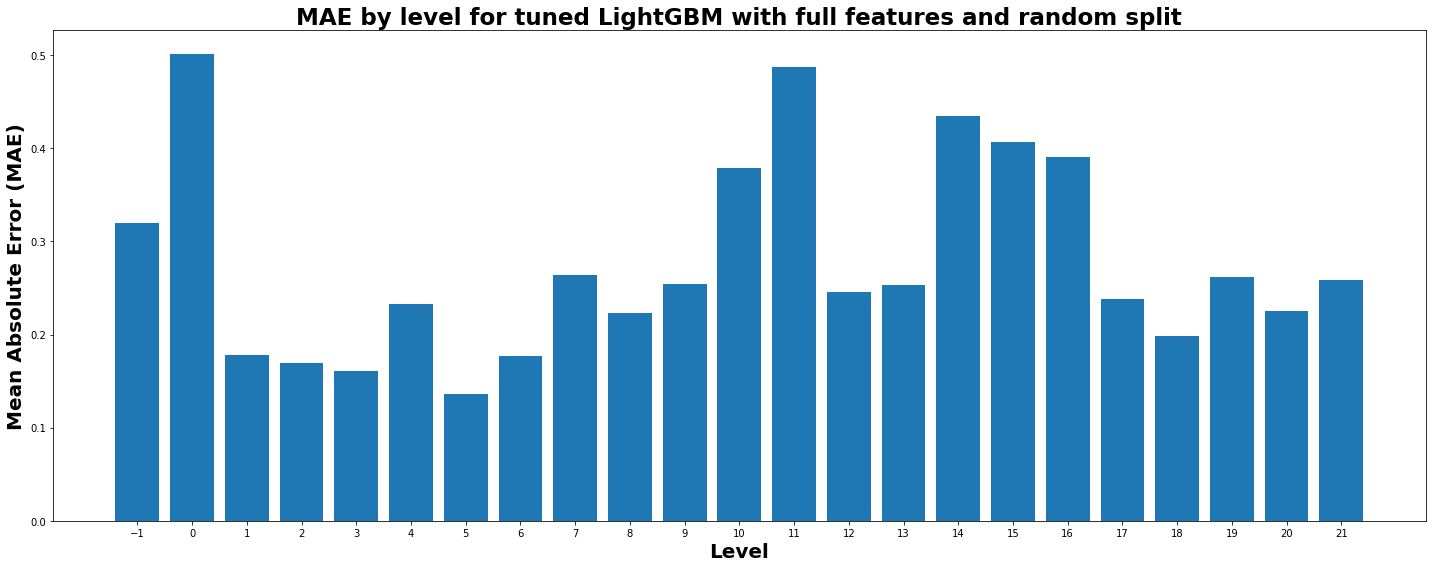

In [118]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with full features and random split",
    export=True,
)

In [119]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.19

Round type: 0.5
RMSE: 0.18

Round type: 0.33
RMSE: 0.22

Round type: 0.45
RMSE: 0.17



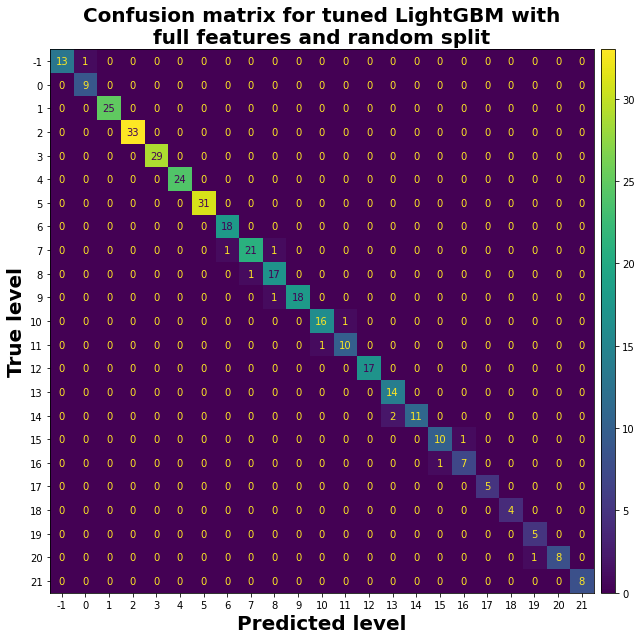

In [120]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with\nfull features and random split",
    export=True,
)

### Best features

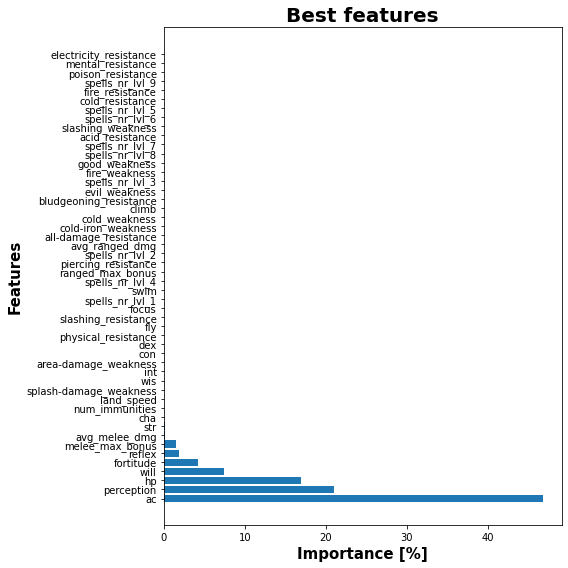

In [121]:
lgb_importances = lgb_tuned.feature_importance(importance_type="gain")
lgb_importances = (lgb_importances / lgb_importances.sum()) * 100
feature_names = lgb_tuned.feature_name()


data = list(zip(lgb_importances, feature_names))
sorted_data = sorted(data, key=lambda x: x[0], reverse=True)
lgb_importances, feature_names = zip(*sorted_data)

plt.figure(figsize=(8, 8))
plt.barh(feature_names, lgb_importances)
plt.xlabel("Importance [%]", fontweight="bold", fontsize=15)
plt.ylabel("Features", fontweight="bold", fontsize=15)
plt.title("Best features", fontweight="bold", fontsize=20)
plt.tight_layout()

plt.show()

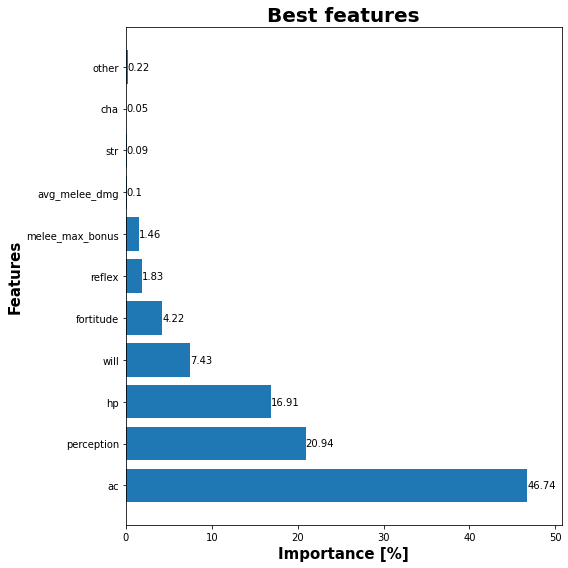

In [128]:
top_features = sorted_data[:10]
lgb_importances, feature_names = zip(*top_features)

lgb_importances = list(lgb_importances)
feature_names = list(feature_names)

lgb_importances.append(100 - sum(lgb_importances))
feature_names.append("other")


plt.figure(figsize=(8, 8))
bars = plt.barh(feature_names, lgb_importances, label=lgb_importances)
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        round(bar.get_width(), 2),
        ha="left",
        va="center",
    )


plt.xlabel("Importance [%]", fontweight="bold", fontsize=15)
plt.ylabel("Features", fontweight="bold", fontsize=15)
plt.title("Best features", fontweight="bold", fontsize=20)

plt.xlim(0, max(lgb_importances) + 4)

plt.tight_layout()
plt.savefig(f"../results_diagrams/other/Best features.svg")
plt.show()

## Summary

In [123]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,full,0.961949,0.464806
1,chronological,Optuna,full,0.725729,0.410218
2,random,default,full,0.371349,0.246737
3,random,Optuna,full,0.309018,0.214958


In [124]:
from training.results import plot_summary

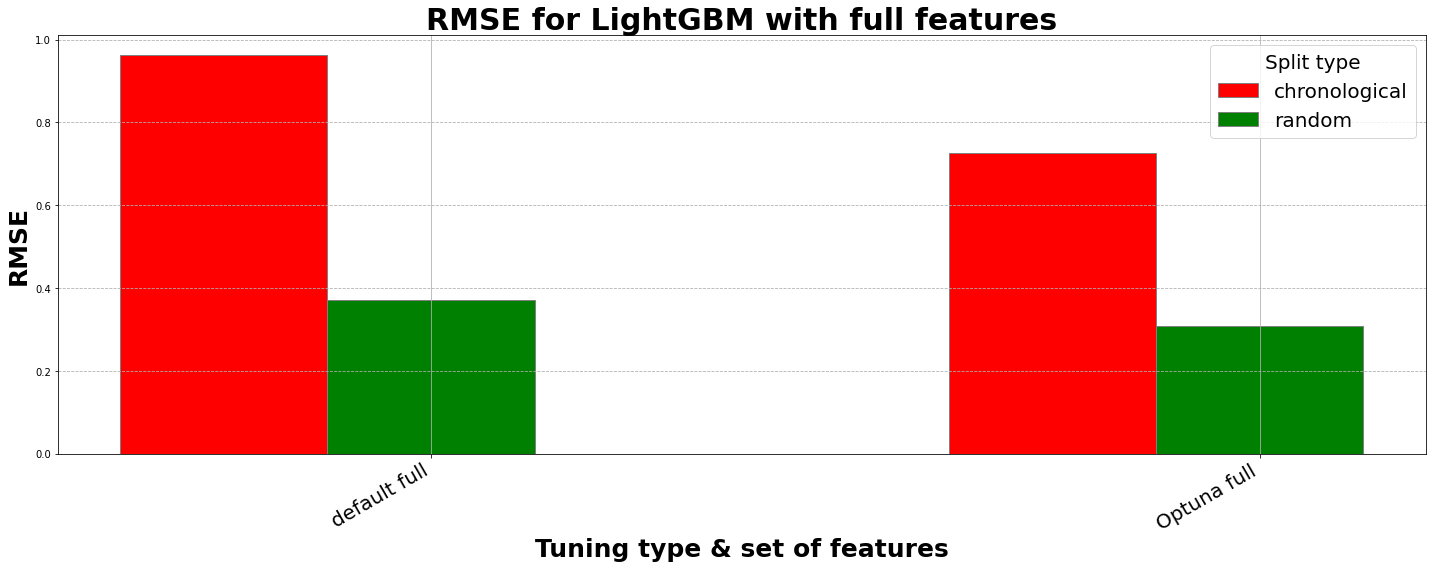

In [125]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with full features")

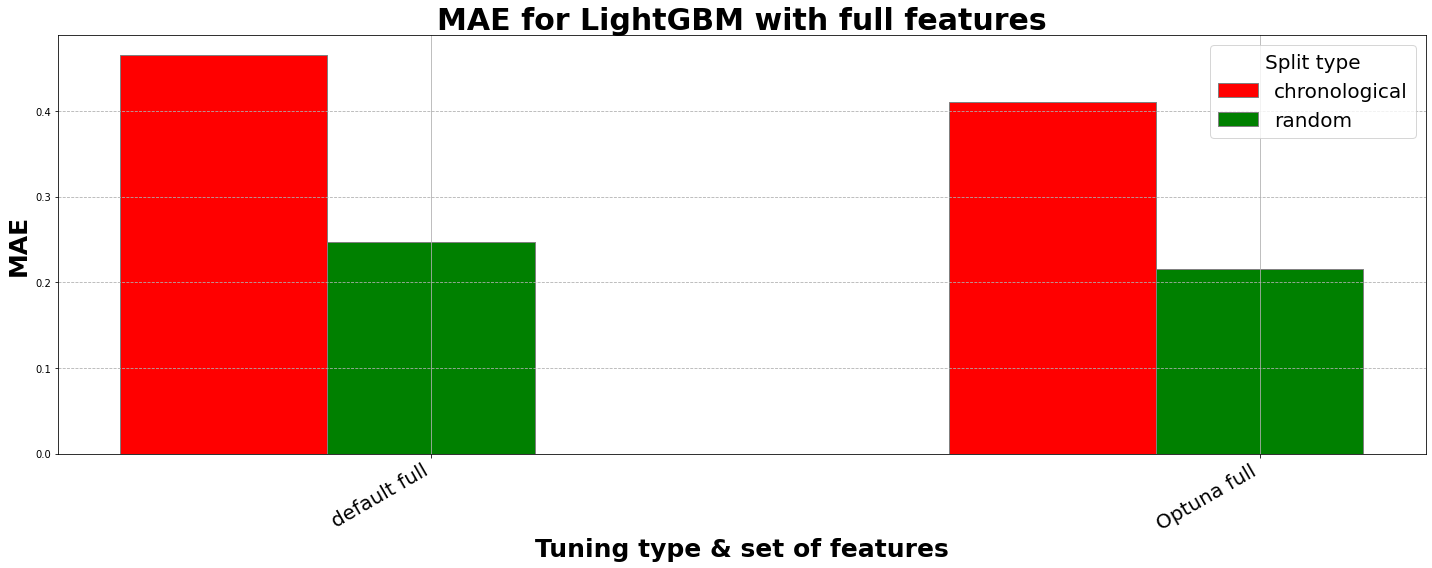

In [126]:
plot_summary(results, "MAE", title="MAE for LightGBM with full features")

In [127]:
results.to_csv("./lightgbm_full_results.csv")